# Сборный проект-4

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Загрузка данных




Импортируем библиотеки и модули, необходимые для выполнения проекта:

In [190]:
!python -m spacy download en_core_web_sm

2023-04-07 01:26:41.107260: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 01:26:43.136836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 01:26:43.169591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 01:26:43.170955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [191]:
!pip install nltk

In [192]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import spacy
import torch
import torch.nn as nn
import torchvision.models as models
from math import ceil
from math import sqrt
from nltk.corpus import stopwords as nltk_stopwords
from PIL import Image
from scipy.spatial import distance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, tqdm_notebook 
from torchvision import transforms
from sklearn.preprocessing import  StandardScaler 






В файле train_dataset.csv собрана информация, необходимая для обучения: 
- имя файла изображения, 
- идентификатор описания
- текст описания. 

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.


In [193]:
train_dataset = pd.read_csv('train_dataset.csv')
train_dataset

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


Вызовем метод info(), чтобы вывести информацию о таблице:

In [194]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В train_dataset 5822 записи, пустых строк нет.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
* 
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

Сохраним данные из файла CrowdAnnotations.tsv в переменную `crowd_annotations` с помощью метода read_csv(). Для того, чтобы первая строка не становилась названиями колонок, передадим в метод параметр header=None и названия столбцов в параметр names:

In [195]:
crowd_annotations = pd.read_csv('CrowdAnnotations.tsv',  sep='\t', header=None, names=['image', 'query_id', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'])
crowd_annotations

,image,query_id,percentage_confirmed,quantity_confirmed,quantity_disproved
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


Вызовем метод info(), чтобы вывести информацию о таблице:

In [196]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 47830 non-null  object 
 1   query_id              47830 non-null  object 
 2   percentage_confirmed  47830 non-null  float64
 3   quantity_confirmed    47830 non-null  int64  
 4   quantity_disproved    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В crowd_annotations 47830 записей, пустых строк нет.

Вызовем метод `describe()`, чтобы лучше изучить таблицу:

In [197]:
crowd_annotations.describe()

,percentage_confirmed,quantity_confirmed,quantity_disproved
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


Из таблицы можно сделать следующие выводы по столбцам:

- `percentage_confirmed`: В среднем 6,8% опрошенных подтверждают, что описание соответствует изображению. При этом медианное значение - 0. Минимальное значение -0, максимальное - 1, а это означает, что есть изображения с описанием, которое подвердили абсолютно все. 
  
- `quantity_confirmed`: Медианное значение - 0, при этом минимальное значение - 0, максимальное 5.
  
- `quantity_disproved`: Медианное значение - 3, значит, чаще всего 3 человека опровергают то, что описание соответствует картинке. При этом минимальное значение - 0, максимальное 6.

В файле test_queries.csv находится информация, необходимая для тестирования: 
- идентификатор запроса, 
- текст запроса
- релевантное изображение

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.


In [198]:
test_queries = pd.read_csv('test_queries.csv', sep='|', index_col=0)
test_queries

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


Вызовем метод info(), чтобы вывести информацию о таблице:

In [199]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В test_queries 500 записи, пустых строк нет.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

Сохраним данные из файла ExpertAnnotations.tsv в переменную expert_annotations с помощью метода read_csv(). Для того, чтобы первая строка не становилась названиями колонок, передадим в метод параметр header=None и названия столбцов в параметр names:

In [200]:
expert_annotations = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
expert_annotations

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


Вызовем метод info(), чтобы вывести информацию о таблице:

In [201]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В expert_annotations 5822 записи, пустых строк нет.

Вызовем метод `describe()`, чтобы лучше изучить таблицу:

In [202]:
expert_annotations.describe()

,expert_1,expert_2,expert_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Аномальных значений в таблице нет, при этом видно, что третий эксперт оценивает совпадение описания и изображений баллами выше, чем его коллеги. Так медиана для эксперта 3 составляет 2 балла, в то время как для других она равна 1. 

**Выводы**

Загрузили данные и сохранили их в переменные. Выяснили, что в результате краудсорсинга с среднем только  6,8% опрошенных подтверждают, что описание соответствует изображению, при этом медианное значение - 0. 

Помимо этого выявили, что третий эксперт, согласно медиане и среднему значению, оценивает совпадение описания и изображений баллами выше, чем его коллеги (2 балла против 1). В 75% случаев все три эксперта оценивают соответствие не выше 2, что означает несоответствие описания изображению. 

## Исследовательский анализ данных


Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 

Для решения задачи мы должны эти оценки агрегировать — превратить в одну. Сделаем это с помощью голосования большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст удалим из датасета:

In [203]:
# Исключим пары изображение-текст, где каждый эксперт поставил разные оценки
unique_votes = expert_annotations.loc[:,['expert_1', 'expert_2', 'expert_3']].apply(pd.Series.nunique, axis=1)
mask = unique_votes <= 2
expert_annotations = expert_annotations[mask]

# Определим количество голосов каждого эксперта за каждую оценку
votes = expert_annotations.apply(pd.Series.value_counts, axis=1)
# Найдем оценки, за которые проголосовала большая часть экспертов
majority_vote = votes.idxmax(axis=1)
# Запишем эти оценки в новый столбец итоговой таблицы
expert_annotations['majority_vote'] = majority_vote
expert_annotations

<ipython-input-203-30fdfc1f0bd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_annotations['majority_vote'] = majority_vote


,image,query_id,expert_1,expert_2,expert_3,majority_vote
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


Объединим таблицы с экспертными и краудсорсинговыми оценками по столбцам 'image' и 'query_id' так, чтобы все строки с экспертными оценками были в итоговой таблице.
Затем создадим функцию, которая агрегирует эти оценки по следующему правилу: если в строке есть обе оценки, тогда оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4. Если же краудсорсинговой оценки нет, тогда оценка эксперта принимается с коэффициентом 1.

А так как экспертные оценки варьируются от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — а  4 — запрос и текст соответствуют полностью, то 1 должно соответствовать вероятности 0, а 4 - вероятности 1.


In [204]:
# Объединим таблицы по столбцам 'image' и 'query_id'
merged_df = pd.merge(expert_annotations, crowd_annotations, on=['image', 'query_id'], how='left').drop(['expert_1', 'expert_2', 'expert_3'], axis=1)

#функция которая подсчитывает средний результат и возвращает его
def average_score(row):
    majority_vote = row.loc['majority_vote']
    percentage_confirmed = row.loc['percentage_confirmed']
    #проверяем есть ли краудсорсинговая оценка в строке
    if math.isnan(percentage_confirmed) :
        score = (majority_vote-1)/3
    else:
        score = (majority_vote-1)/3*0.6 + percentage_confirmed*0.4
    return score

merged_df['average_score']=merged_df.apply(average_score, axis=1)
merged_df = merged_df.drop(['majority_vote', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'], axis=1)
merged_df

,image,query_id,average_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000
...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.000000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000


Проверим с помощью метода describe(), как сработало заполнение:

In [205]:
merged_df.describe()

,average_score
count,5696.000000
mean,0.172265
std,0.261057
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


Заполнение сработало корректно, минимальное значение - 0, максимальное - 1. Но при этом 75% значений лежит в диапазоне от 0 до 0,33, что указывает на дисбаланс.

## Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Cделаем это в несколько этапов:

1) Предобработаем тексты описаний. Приведем все к нижнему регистру, очистим от ненужных символов(если таковые имеются), а также лемматизируем их.

2) Создадим список слов, которые прямо указывают на ребенка на изображении, а также список слов, которые могут указывать, но только в сочетании с определенными прилагательными.
   
3) Удалим нужные строки из таблицы при помощи написанной функции.

Сначала переведем все описания к нижнему регистру:

In [206]:
train_dataset['query_text'] = train_dataset['query_text'].str.lower()

Создадим 2 функции, которые лемматизируют комментарии (функция lemmatize(text)) и очистят их от ненужных символов(clear_text(text)), если таковые есть:

In [207]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    lemm_list = nlp(text)
    lemm_text = str(lemm_list)
        
    return lemm_text


def clear_text(text):
    processed_text = re.sub(r'[^A-Za-z ]', ' ', text)
    return ' '.join(processed_text.split())

Применим написанные функции к нашему датасету. Сначала отчистим данные от ненужных символов с помощью clear_text(x). Для того, чтобы был виден прогресс выполнения кода, вызовем вместо метода apply() другой - progress_apply():

In [208]:

tqdm.pandas()
train_dataset['query_text'] = train_dataset['query_text'].progress_apply(lambda x: clear_text(x))

100%|██████████| 5822/5822 [00:00<00:00, 233052.47it/s]


Теперь проведем лемматизацию комментариев при помощи метода lemmatize():

In [209]:
train_dataset['query_text'] = train_dataset['query_text'].progress_apply(lambda x: lemmatize(x))

100%|██████████| 5822/5822 [00:44<00:00, 131.17it/s]


Теперь создадим списки слов, а также функцию, которая проверит на содержание этих слов в текстах:

In [210]:

# список слов, которые могут попадать под ограничения:
#слова однозначно обозначающие детей до 18 лет
restricted_words = ['baby', 'babies', 'girl', 'boy', 'girls', 'boys', 'child',  'children', 'kid', 'kids', 'juvenile', 'minor', 'minors', 'youth', 'youths', 'teen', 'teens', 'teenager', 'teenagers', 'underage']

def check_restricted_words(row):
    text = row.loc['query_text']
    for word in text.split():
        if word in restricted_words:
            return True


    return False
# добавляем столбец с признаком наличия "запрещенных" слов в тексте
train_dataset['restricted_words'] = train_dataset.apply(check_restricted_words, axis=1)
#удалим строки, содержащие описание с детьми
train_dataset = train_dataset[~train_dataset['restricted_words']].drop('restricted_words', axis=1)
train_dataset

,image,query_id,query_text
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street
...,...,...,...
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,a small animal leaps behind a larger animal th...
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,a dog stands on the side of a grassy cliff
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,a blurry photo of two dogs


Видим, что очищенный датасет теперь состоит из 4274 строк. То есть было удалено 1422 строки.

Так как потом нам надо будет обучать модель на основе описаний, изображений и агрегированных оценок, то соединим train_dataset и merged_df на основе пары значений 'image' и 'query_id':

In [211]:
train_dataset = pd.merge(train_dataset, merged_df, on=['image', 'query_id'], how='inner')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4185 entries, 0 to 4184
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          4185 non-null   object 
 1   query_id       4185 non-null   object 
 2   query_text     4185 non-null   object 
 3   average_score  4185 non-null   float64
dtypes: float64(1), object(3)
memory usage: 163.5+ KB


## Векторизация изображений

Перейдём к векторизации изображений.

Сделаем это с помощью ResNet-18, исключив полносвязные слои, которые отвечают за конечное предсказание:

In [212]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель 

/opt/python/envs/default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Нам не надо обучать модель, поэтому заморозим веса:

In [213]:
for param in resnet.parameters():
    param.requires_grad_(False) 

Нам нужно взять все слои, кроме последних двух:

In [214]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 
#переводим модель в режим предсказания:
resnet.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [215]:
#данные для преобразования изображений
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

На основе кода выше создадим функцию complete_image_vec(name, path) для создания эмбеддинга для изображений: 

In [216]:
image_vec = []
path = "/data/notebook_files/train/"

def complete_image_vec(name, path):
    img = Image.open(path+name).convert('RGB')
    image_tensor = preprocess(img)
    image_tensor = image_tensor.unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    image_vec.append(output_tensor)
    


Применим написанную функцию для столбца train_dataset['image']:

In [217]:
train_dataset['image'].progress_apply(lambda x: complete_image_vec(x, path))
outputs_tensor = torch.stack(image_vec)

100%|██████████| 4185/4185 [01:54<00:00, 36.51it/s]


## Векторизация текстов

Следующий этап — векторизация текстов. Сделаем это с помощью tf-idf:

Создадим корпус описаний. Преобразуем столбец 'query_text' в список текстов:

In [218]:
train_corpus = train_dataset['query_text'].values

С помощью nltk избавимся от стоп-слов, а с помощью TfidfVectorizer подсчитаем величину TF-IDF для текстов:

In [219]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

text_vec = count_tf_idf.fit_transform(train_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Объединение векторов


Добавим в признаки модели Евклидово расстояние между вектором изображения и вектором текста. Для этого сначала приведем тензор изображений к типу array.numpy:

In [220]:
image_vector = outputs_tensor.numpy()

Далее напишем функцию euclidean_distance, которая на вход принимает вектор текстов, изображений и переменную, чтобы в нее сохранить массив вычисленных расстояний.

In [221]:
distances=[]
def euclidean_distance(text_vec, image_vector, distances):
    for i in range(text_vec.shape[0]):
        text = text_vec[i].toarray()
        image = image_vector[i]
        #приведем векторы к одной размерности

        new_size = image_vector.shape[1]

        num_zeros = new_size - text.shape[1]

        
    # Создаем новый вектор с добавленными нулями в конец
        text = np.pad(text, ((0, 0), (0, num_zeros)), 'constant', constant_values=(0))

    #считаем Евклидово расстояние между векторами
        d = distance.euclidean(text.flatten(), image.flatten())
        distances.append(d)

euclidean_distance(text_vec, image_vector, distances)

Создадим тензор расстояний:

In [222]:
distances_tensor = torch.tensor(distances)

Для дальнейшего объединения векторов надо изменить размерность у полученного тензора:

In [223]:
distances_tensor = distances_tensor.reshape(4185,1)

Объединим векторы изображений, векторы текстов и вектор с Евклидовыми расстояними с целевой переменной.

In [224]:
# Преобразование text_vec в Tensor
text_vec = torch.tensor(text_vec.todense())

# Объединение векторов
combined_vec = torch.cat((outputs_tensor, text_vec, distances_tensor), axis=1)

Посмотрим, какой размерности получился тензор признаков:

In [225]:
combined_vec.shape

torch.Size([4185, 26223])

## Обучение модели предсказания соответствия

Обозначим целевую переменную. Это столбец average_score:

In [226]:
target = train_dataset['average_score']

Разобьем тренировочный датасет на обучающую и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом GroupShuffleSplit из библиотеки sklearn.model_selection:

In [227]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=combined_vec, y=target, groups=train_dataset['image']))
features_train, features_test = combined_vec[train_indices], combined_vec[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

Применим StandartScaler, чтобы стандартизировать данные:

In [228]:

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Начнем обучение с модели Линейной регрессии. В качестве метрики выберем RMSE:

In [229]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression()

In [230]:

# Прогнозирование на тестовой выборке
y_pred = lr_model.predict(features_test)

# Вычисление rmse
rmse = mean_squared_error(target_test, y_pred)
rmse


6.62322671222115e+24

Как видим, значение RMSE 6.62322671222115e+24, что слишком много, учитывая то, что целевые значения лежат в промежутке от 0 до 1. 

Для визуального понимания построим графики значений предсказаний модели и целевой переменной:

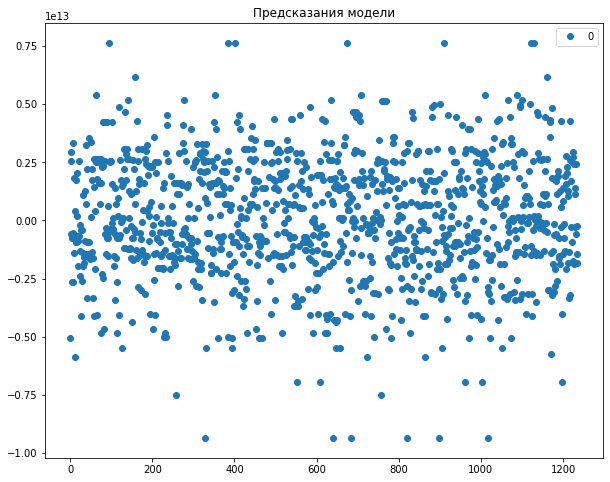

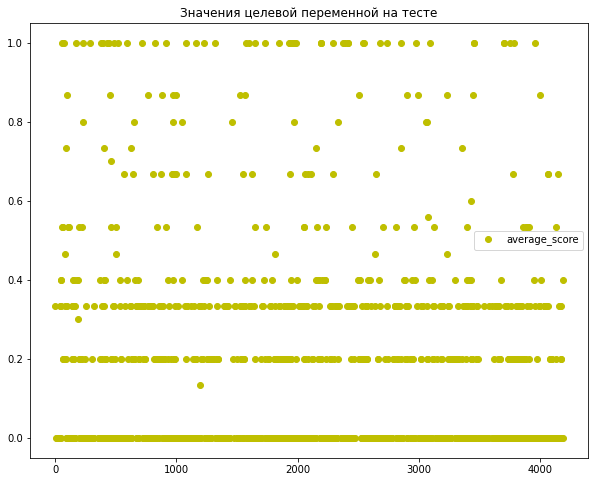

In [231]:
pd.DataFrame(y_pred).plot(style='o', figsize=(10,8), title='Предсказания модели')
pd.DataFrame(target_test).plot(style='o',color='y', figsize=(10,8), title='Значения целевой переменной на тесте')
plt.show()

Как видим, различия значительны. Как минимум, достаточно много значений меньше 0, чего не должно быть. Следовательно, надо обучать другую модель для более точного предсказания.

Поэтому создадим нейронную сеть. Разработаем архитектуру нашей нейросети. На входном слое будет 26223 нейронов. На выходном - 1.

В нашей нейросети будет 1 скрытый слой, состоящий из 256 нейронов. В качестве функции активации будем использовать ReLU(), для борьбы с переобучением и недообучением - BatchNorm. Оптимизатором будет Adam(). Для того, чтобы выбрать оптимальный параметр, переберем значения learning rate в цикле. 

После выполнения обучения выведем результаты работы нейросети при разных значениях learning rate в виде таблицы:

In [232]:

#для быстроты выполнения кода отправим его на GPU
DEVICE = 'cuda'
rate_rmse = []
cols = ['learning_rate', 'last_rmse', 'rmse_mean']
#Преобразуем выборки с данными в тензоры.
X_train = torch.FloatTensor(features_train).to(DEVICE)
X_test = torch.FloatTensor(features_test).to(DEVICE)
y_train = torch.FloatTensor(target_train.values).to(DEVICE)
y_test = torch.FloatTensor(target_test.values).to(DEVICE)

n_in_neurons = 26223
n_hidden_neurons_1 = 256
n_out_neurons = 1


net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_1), 
    nn.Linear(n_hidden_neurons_1, n_out_neurons),
    nn.Sigmoid()
    
)


net.to(DEVICE)

learning_rates = [0.009, 0.015, 0.1, 0.001]


for rate in learning_rates:
    optimizer = torch.optim.Adam(net.parameters(), lr=rate)

    loss = nn.MSELoss()

    batch_size = 50

    num_epochs = 150

    num_batches = ceil(len(X_train)/batch_size)

    rmse_mean = []
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train)) # создали случайную перестановку индексов объектов
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size # посчитали номер стартового объекта батча
            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index + batch_size] # извлекли индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            rmse = sqrt(mean_squared_error(y_test.detach().cpu().numpy(), test_preds.detach().cpu().numpy()))
            rmse_mean.append(rmse)

        if epoch == num_epochs - 1:
            rate_rmse.append([rate, rmse, np.mean(rmse_mean)])
rmse_compare_lr = pd.DataFrame(data = rate_rmse, columns=cols)
rmse_compare_lr

,learning_rate,last_rmse,rmse_mean
0,0.009,0.298714,0.287386
1,0.015,0.299726,0.293343
2,0.100,0.321131,0.322512
3,0.001,0.321131,0.321131


Лучшее значение метрики RMSE нейронная сеть показала при learning_rate = 0.009. Поэтому выберем этот показатель в качестве параметра в итоговой модели:

In [233]:
n_in_neurons = 26223
n_hidden_neurons_1 = 256
n_out_neurons = 1


net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_1), 
    nn.Linear(n_hidden_neurons_1, n_out_neurons),
    nn.Sigmoid()
    
)


net.to(DEVICE)


optimizer = torch.optim.Adam(net.parameters(), lr=0.009)

loss = nn.MSELoss()

batch_size = 50

num_epochs = 150

num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train)) # создали случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # посчитали номер стартового объекта батча
        optimizer.zero_grad()
  
        batch_indexes = order[start_index : start_index + batch_size] # извлекли индексы объектов текущего обатча
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
  
        preds = net.forward(X_batch).flatten()
     
        
        loss_value = loss(preds, y_batch)

        loss_value.backward()
       
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        rmse = sqrt(mean_squared_error(y_test.detach().cpu().numpy(), test_preds.detach().cpu().numpy()))
rmse

0.28886338412635565

**Выводы**

Обучили 2 модели: Линейную регрессию и нейронную сеть. Лучшей по показателю RMSE стала нейронная сеть (0.279 против 62322671222115e+24).

Итоговая нейронная сеть имеет следующую архитектуру:
- Входной слой - 26223 нейронов, 1 скрытый слой - 256 нейронов, выходной - 1.
- Функция активации ReLU()
- BatchNorm
- Оптимизатор Adam() с learning rate=0.009.

Итоговая метрика RMSE на уровне 0.279 означает, что в среднем наша модель ошибается на это значение при предсказании агрегированной оценки. Если сравнить это с градацией экспертных оценок (значения от 1 до 4), то можно сказать, что модель ошибается максимум на 1 степень, что в целом не критично влияет на вердикт (подходит описание картинке или нет, так как у смежных оценок различие не радикальное).

## Тестирование модели

Настало время протестировать модель. 
Для этого выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение.

Сначала надо приготовить признаки. Для этого сперва создадим вектор изображений:

In [234]:
#создаем вектор изображений 
path = "/data/notebook_files/test/"
image_vec = []
test_queries['image'].progress_apply(lambda x: complete_image_vec(x, path))
outputs_tensor_test = torch.stack(image_vec)

100%|██████████| 500/500 [00:12<00:00, 39.23it/s]


Теперь напишем функцию, которая будет принимать номер строки (его позже мы рандомно сгенерируем). Далее она проведет проверку на запрещенные слова, и если найдет такие - покажет дисклеймер, а также продублирует поисковый запрос. После проверки функция создаст фиктивный вектор текстов, состоящий из повторенных для каждой строки векторов поискового запроса. Затем мы посчитаем для каждой пары векторов Евклидово расстояние, и из всех значений составим вектор. После конкатенируем полученные вектора - это и будут признаки, которые может принять наша уже обученная модель. 

Наша нейронная сеть уже научена исходя из вектор изображения-вектор текста - расстояние между векторами предсказывать оценку или другими словами оценивать насколько текст и изображение подходят друг другу. В нашей функции мы для каждого изображения оцениваем насколько оно подходит поисковому запросу. 

После оценки находим максимум. Выясняем индекс максимума и по этому индексу находим имя изображения, а затем выводим его на экран. Остается только оценить работу модели. 

In [235]:

#функция для выведения изображения
def find_picture(element):
    text = test_queries.loc[element]['query_text']
    text = text.lower()
    text = lemmatize(text)
#проверка на запрещенные слова
    if check_restricted_words(test_queries.loc[element].str.lower()):
        print('Your try to find:'+" "+text)
        print("This image is unavailable in your country in compliance with local laws")
    else:
        test = test_queries
        test['search_text'] = pd.Series(text, index=test_queries.index)
        #векторизируем наши описания
        test_corpus = test['search_text'].values
        text_vec_test = count_tf_idf.transform(test_corpus)
        #считаем расстояния между векторами
        distances=[]
        euclidean_distance(text_vec_test, outputs_tensor_test.numpy(), distances)
        distances_tensor = torch.tensor(distances)
        distances_tensor = distances_tensor.reshape(500,1)
        # Преобразование text_vec в Tensor
        text_vec_test = torch.FloatTensor(text_vec_test.todense())
        # Объединение векторов
        combined_vec_test = torch.cat((outputs_tensor_test, text_vec_test,distances_tensor), axis=1)
        #тензор признаков
        test_x = torch.FloatTensor(combined_vec_test).to(DEVICE)
        #предскажем оценки с помощью обученной модели
        predictions = net.forward(test_x)
        predictions = predictions.detach().cpu().numpy()
        #получаем индекс искомой картинки
        image_index = predictions.argmax()
        #получаем имя файла искомой картинки
        image_name = test_queries.loc[image_index]['image']
        #выводим искомое изображение на экран
        image = Image.open('/data/notebook_files/test/'+image_name)
        plt.imshow(np.array(image))
        plt.title(text)
        plt.show()
        #выводим изображение из файла под индексом:
        image_name = test_queries.loc[element]['image']
        image = Image.open('/data/notebook_files/test/'+image_name)
        plt.imshow(np.array(image))
        plt.title('FROM TABLE'+" "+text)
        plt.show() 


In [236]:
#создаем массив 10 случайных целых чисел
n = 10
test_array = []
for i in range(n):
    test_array.append(random.randint(0, test_queries.shape[0]))
print(test_array)

[259, 295, 354, 133, 268, 78, 441, 422, 23, 187]


Тестируем модель с помощью написанной функции:

Your try to find: boys and girls at a party .
This image is unavailable in your country in compliance with local laws
Your try to find: a little boy wearing a green soccer strip is running on the grass .
This image is unavailable in your country in compliance with local laws
Your try to find: a little girl with a hat sits between a woman 's feet in the sand in front of a pair of colorful tents .
This image is unavailable in your country in compliance with local laws
Your try to find: a girl in a cape along with other costumed children
This image is unavailable in your country in compliance with local laws


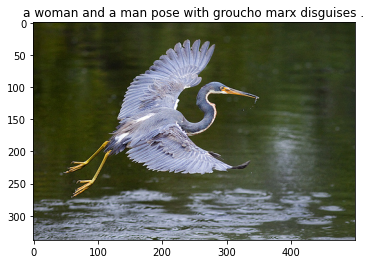

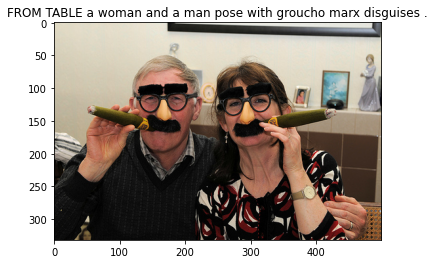

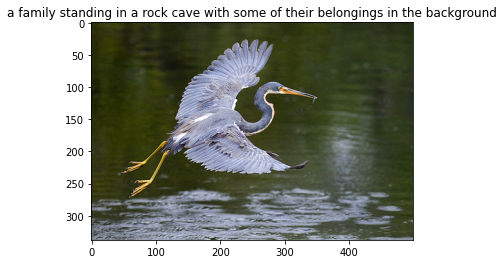

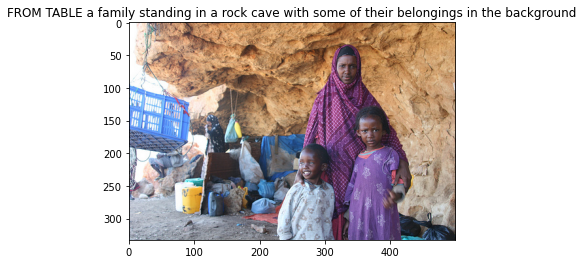

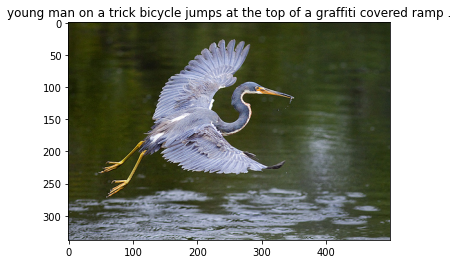

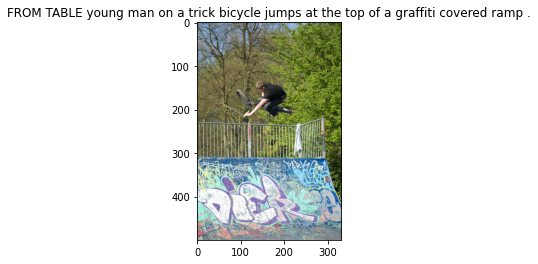

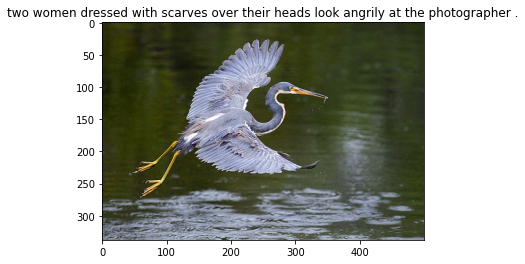

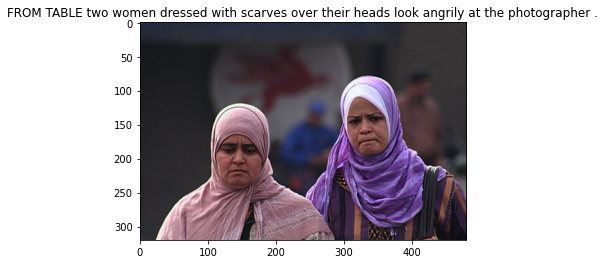

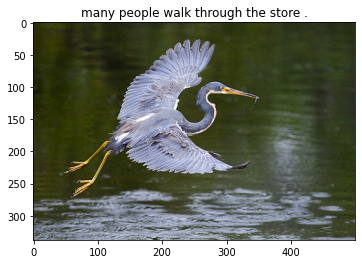

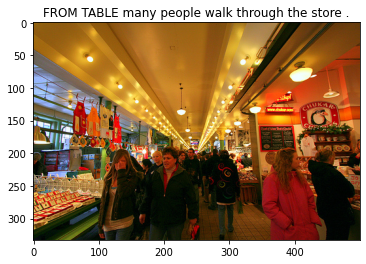

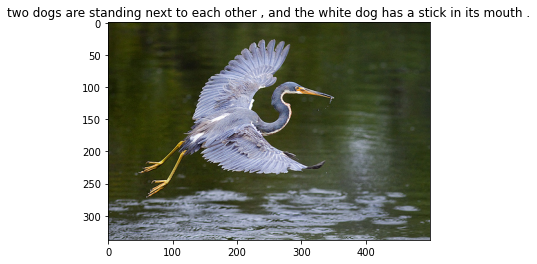

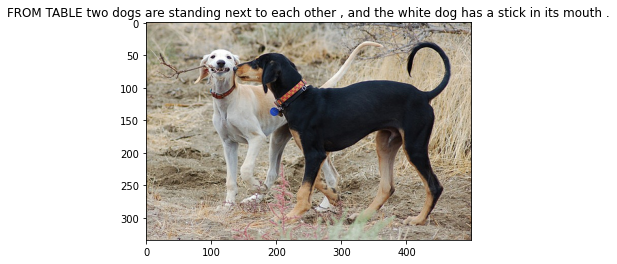

In [237]:
for element in test_array:
    find_picture(element)

**Вывод**

Как видим, функция адекватно отсекла поисковые запросы, связанные с детьми.
Однако тестирование показало, что модель, к сожалению, неадекватно выставляет оценки. Вне зависимости от поискового запроса, модель предсказывает максимальное значение итоговой оценки одной и той же картинке. Соответственно можно сделать вывод, что использовать ее для качественного поиска нельзя.

## Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска